In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from PIL import Image
import random

import kagglehub
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

100%|██████████| 385M/385M [00:17<00:00, 22.9MB/s]

Extracting files...


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2"

# csv_path = os.path.join(dataset_path, "cards.csv")
# df = pd.read_csv(csv_path)
# print(df.head())  #first few rows
os.listdir(dataset_path)

['test',
 'train',
 '53cards-53-(200 X 200)-100.00.h5',
 'cards.csv',
 '14card types-14-(200 X 200)-94.61.h5',
 'valid']

In [ ]:
class AceAI_DF(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
df = AceAI_DF(
    data_dir= data_dir
)

card_dict = {i: card for card, i in ImageFolder(data_dir).class_to_idx.items()}
print(card_dict)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = AceAI_DF(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    break

print(images.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


# AceAI

In [ ]:
class AceAI(nn.Module):

    def __init__(self, num_classes=53):

        super(AceAI, self).__init__()

        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280

        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = AceAI(num_classes=53)
print(str(model)[:500])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

AceAI(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          


In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
valid_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid'
test_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test/'

train_dataset = AceAI_DF(train_folder, transform=transform)
val_dataset = AceAI_DF(valid_folder, transform=transform)
test_dataset = AceAI_DF(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Simple training loop
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AceAI(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)  # Get predicted class (index of max logit)
    correct = (preds == labels).sum().item()  # Count the correct predictions
    accuracy = correct / labels.size(0)  # Calculate accuracy
    return accuracy

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        running_accuracy += compute_accuracy(outputs, labels) * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_accuracy / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            running_accuracy += compute_accuracy(outputs, labels) * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = running_accuracy / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy * 100:.2f}%")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/20 - Train loss: 1.5504, Train accuracy: 57.14%, Validation loss: 0.4438, Validation accuracy: 86.42%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/20 - Train loss: 0.5291, Train accuracy: 84.88%, Validation loss: 0.1827, Validation accuracy: 95.09%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/20 - Train loss: 0.3243, Train accuracy: 90.39%, Validation loss: 0.1947, Validation accuracy: 93.58%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/20 - Train loss: 0.2430, Train accuracy: 92.68%, Validation loss: 0.2670, Validation accuracy: 94.72%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/20 - Train loss: 0.1973, Train accuracy: 94.33%, Validation loss: 0.2359, Validation accuracy: 93.58%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/20 - Train loss: 0.1586, Train accuracy: 95.02%, Validation loss: 0.1737, Validation accuracy: 95.09%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/20 - Train loss: 0.1271, Train accuracy: 96.14%, Validation loss: 0.1312, Validation accuracy: 96.60%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/20 - Train loss: 0.1089, Train accuracy: 96.59%, Validation loss: 0.1874, Validation accuracy: 94.72%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/20 - Train loss: 0.1235, Train accuracy: 96.38%, Validation loss: 0.2327, Validation accuracy: 94.34%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/20 - Train loss: 0.0982, Train accuracy: 97.14%, Validation loss: 0.1833, Validation accuracy: 94.72%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/20 - Train loss: 0.1138, Train accuracy: 96.35%, Validation loss: 0.1625, Validation accuracy: 95.85%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/20 - Train loss: 0.0888, Train accuracy: 97.36%, Validation loss: 0.1842, Validation accuracy: 96.23%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/20 - Train loss: 0.0658, Train accuracy: 97.89%, Validation loss: 0.2173, Validation accuracy: 94.34%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/20 - Train loss: 0.0629, Train accuracy: 98.19%, Validation loss: 0.1475, Validation accuracy: 95.85%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/20 - Train loss: 0.0901, Train accuracy: 97.21%, Validation loss: 0.0908, Validation accuracy: 96.98%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/20 - Train loss: 0.0893, Train accuracy: 97.28%, Validation loss: 0.2005, Validation accuracy: 95.85%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/20 - Train loss: 0.0608, Train accuracy: 98.14%, Validation loss: 0.1621, Validation accuracy: 96.60%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/20 - Train loss: 0.0994, Train accuracy: 97.30%, Validation loss: 0.1078, Validation accuracy: 96.60%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/20 - Train loss: 0.0577, Train accuracy: 98.33%, Validation loss: 0.1494, Validation accuracy: 96.23%


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/20 - Train loss: 0.0550, Train accuracy: 98.19%, Validation loss: 0.0856, Validation accuracy: 97.74%


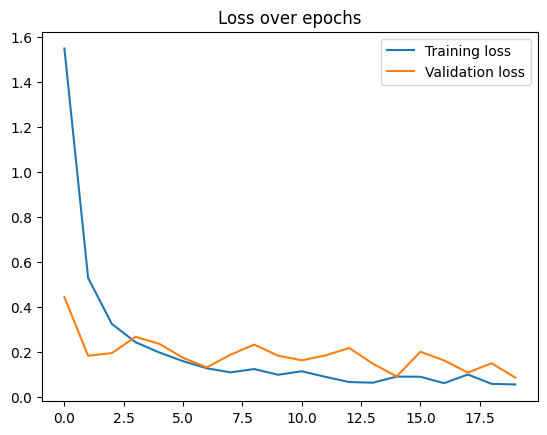

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)





def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()





def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

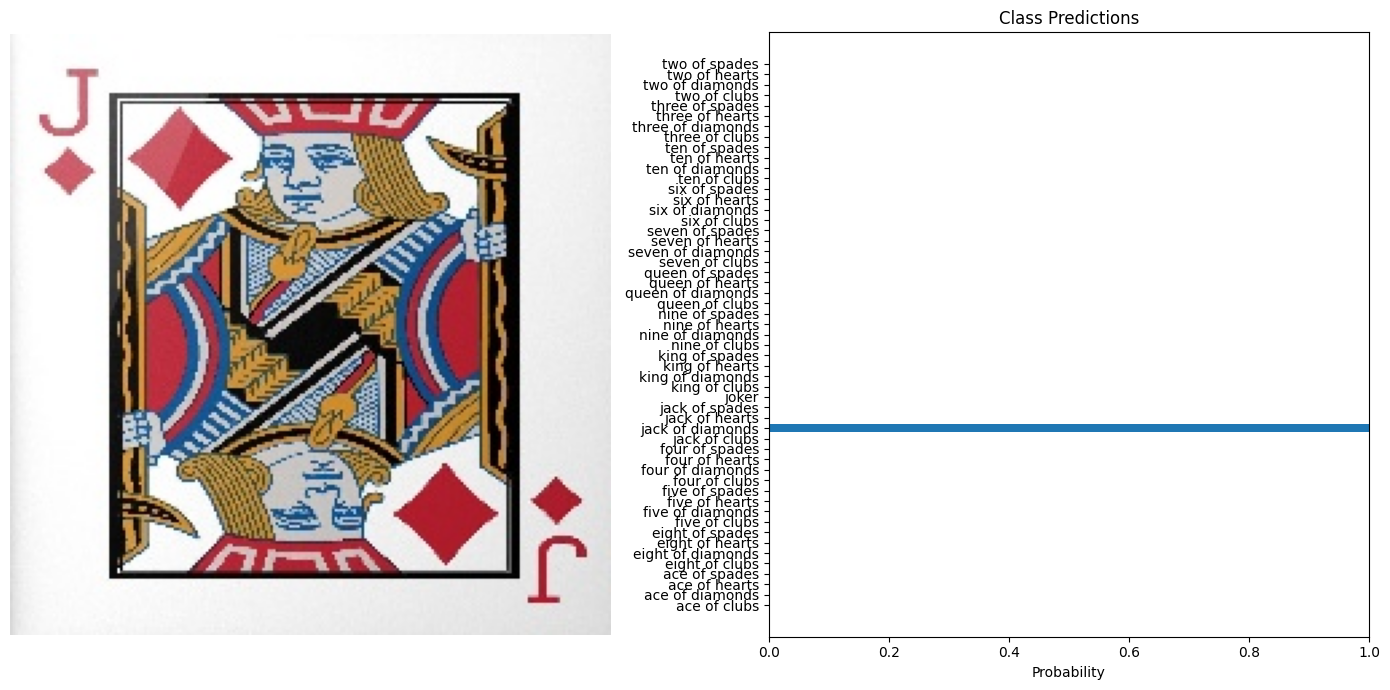

In [ ]:
test_dir = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'

class_names = os.listdir(test_dir)
random_class = random.choice(class_names)
class_folder = os.path.join(test_dir, random_class)
image_files = os.listdir(class_folder)
random_image = random.choice(image_files)
test_image = os.path.join(class_folder, random_image)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

In [ ]:
torch.save(model.state_dict(), 'AceAI.pth')